# Quickstart to parcels -- Initial Times

## Basic setup

In [1]:
from pathlib import Path
example_data_path = Path("../parcels_example_data/")

## Importing relevant modules

We need to import `parcels` itself along with `matplotlib`, `xarray`, and `datetime`.

In [2]:
import parcels

from matplotlib import pyplot as plt
import cartopy

import xarray as xr
import numpy as np

import datetime

## Create FieldSet

Load the example data from the `"GlobCurrent_example_data"` directory.
Filesnames are starting with a year in the 2000's.


Hints:
- use the `.from_netcdf()` method to create the fieldset
- variable `"eastward_eulerian_current_velocity"` is `"U"`
- variable `"northward_eulerian_current_velocity"` is `"V"`.
- dimensions are `"time"`, `"lon"`, `"lat"`.

In [3]:
GlobCurrent_example_data_path = example_data_path / "GlobCurrent_example_data"

In [4]:
filenames = {
    "U": GlobCurrent_example_data_path / "20*.nc",
    "V": GlobCurrent_example_data_path / "20*.nc",
}

In [5]:
variables = {
    "U": "eastward_eulerian_current_velocity",
    "V": "northward_eulerian_current_velocity",
}
dimensions = {"lat": "lat", "lon": "lon", "time": "time"}

In [6]:
fieldset = parcels.FieldSet.from_netcdf(filenames, variables, dimensions, deferred_load=False)

## Create ParticleSet

Now define a `ParticleSet`, in this case with 2_000 particle starting randomly distributed within the bounds of the fieldset. Use the `ParticleSet.from_list` constructor method again.

In [7]:
number_particles = 1_000
lon_bds = (24, 27)
lat_bds = (-39, -34.5)

We'll spawn particles equally spread out over the first 2 days.
To avoid any un-ambiguities with rounding, we set particles to times which are exactly output-times. As we will use hourly output, 
we start particles on full hours.

In [8]:
pset = parcels.ParticleSet.from_list(
    fieldset=fieldset,
    pclass=parcels.JITParticle,
    lon=np.random.uniform(*lon_bds, size=(number_particles, )),
    lat=np.random.uniform(*lat_bds, size=(number_particles, )),
    time=np.round(np.linspace(0, 48, number_particles)) * 3600 + fieldset.U.grid.time[0],
)

## Execute

Create an error-handling kernel which deletes particles with too high status codes.

(See https://docs.oceanparcels.org/en/latest/examples/tutorial_kernelloop.html#Working-with-Status-Codes) 

In [9]:
def CheckError(particle, fieldset, time):
    if particle.state >= 50:  # This captures all Errors
        particle.delete()

Execute the `ParticleSet` for 10 days at 5-minute time step using the 4th order Runge-Kutta kernel and the Error Kernel above.
Capture output every 6 hours.

In [10]:
output_file = pset.ParticleFile(
    name="GlobCurrentParticles_times.zarr",
    outputdt=datetime.timedelta(hours=1),
    chunks=(number_particles, 4),
)
pset.execute(
    [parcels.AdvectionRK4, CheckError],
    runtime=datetime.timedelta(days=10),
    dt=datetime.timedelta(minutes=5),
    output_file=output_file,
)

INFO: Output files are stored in GlobCurrentParticles_times.zarr.
100%|██████████| 864000.0/864000.0 [03:21<00:00, 4289.72it/s]


## Have a look at the output

In [11]:
ds = xr.open_zarr("GlobCurrentParticles_times.zarr").compute()
ds

<xarray.Dataset> Size: 5MB
Dimensions:     (trajectory: 1000, obs: 240)
Coordinates:
  * obs         (obs) int32 960B 0 1 2 3 4 5 6 7 ... 233 234 235 236 237 238 239
  * trajectory  (trajectory) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
Data variables:
    lat         (trajectory, obs) float32 960kB -34.82 -34.82 -34.82 ... nan nan
    lon         (trajectory, obs) float32 960kB 24.96 24.91 24.87 ... nan nan
    time        (trajectory, obs) datetime64[ns] 2MB 2002-01-01 ... NaT
    z           (trajectory, obs) float32 960kB 0.0 0.0 0.0 0.0 ... nan nan nan
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4CheckError
    parcels_mesh:           spherical
    parcels_version:        3.0.6

Plot initial times

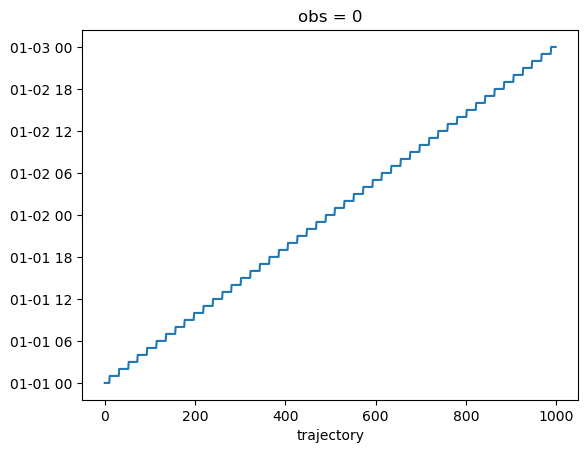

In [12]:
ds.time.isel(obs=0).plot()